In [353]:
if not 'matlab_loaded' in globals():
    print('load matlab')
    import matlab.engine
    eng = matlab.engine.start_matlab()
    eng.addpath ('D:/onedrive_ntpu/OneDrive - 國立臺北大學/vicon dataset 2/Preprocessing', nargout= 0 )
    matlab_loaded = True
    print('matlab loaded')

## Read file

In [2]:
import numpy as np
import os
import pandas as pd
from math import floor

motion_type = "hand_wave"
motion_name = "fast_sh_1"
vicon_name = "20240109 hand wave fast sh 1"

motion_part = "arm"
com_port = "23"

# motion_part = "leg"
# com_port = "22"

# syn_suffix=""
syn_suffix="_x"

dir_root = "D:/onedrive_ntpu/OneDrive - 國立臺北大學/"

imu_file = dir_root+"vicon dataset 2/imu/"+motion_type+"/"+motion_name+"/data_COM"+com_port+".csv"
mag_offset_file = dir_root+"vicon dataset 2/imu/"+motion_type+"/"+motion_name+"/offset_COM"+com_port+".csv"
vicon_file = dir_root+"vicon dataset 2/vicon data trim/"+motion_type+"/"+vicon_name+".csv"
syn_path = dir_root+"vicon dataset 2/syn3/"+motion_type+"/"+motion_name+"_"+motion_part+syn_suffix+"/"

do_correct_offset = True
correct_mag_offset_file = dir_root+"vicon dataset 2/offset/offset_"+com_port+"/offset_COM"+com_port+".csv"

imu_df = pd.read_csv(imu_file).values
imu_acc = imu_df[:,6:9]
imu_gyr = imu_df[:,9:12]
imu_mag_raw = imu_df[:,12:15]
imu_time = imu_df[:,15]
imu_duration = (imu_time[-1] - imu_time[0]) * 1000
print(f"imu start: {imu_time[0]} s")
print(f"imu end: {imu_time[-1]} s")
print(f"imu duration: {imu_duration} ms")
print(f"imu freq: {imu_time.shape[0]/imu_duration*1000} Hz")
print(f"data length: {imu_time.shape[0]}")

# vicon_pd = pd.read_csv(vicon_file)
vicon_pd = pd.read_csv(vicon_file, skiprows=4)

# interpolation of dataframe
# for i,c in enumerate(vicon_pd.columns):
#     if i%3 == 1:
#         vicon_pd[c] = vicon_pd[c].interpolate(method='spline', order=1, axis=0, limit_direction='forward')
#     else:
#         vicon_pd[c] = vicon_pd[c].interpolate(method='cubicspline', axis=0, limit_direction='forward')

vicon_df = vicon_pd.values

# vicon_df = vicon_pd.values[:,2:-4]


print(f"vicon shape: {vicon_df.shape}")
vicon_points = np.hsplit(vicon_df[:,:floor(vicon_df.shape[1]/3)*3],floor(vicon_df.shape[1]/3))
vive_duration = vicon_df.shape[0] * 10

print(f"vicon duration: {vive_duration} ms")

os.makedirs(syn_path,exist_ok=True)

imu_mag = np.array(imu_mag_raw)

# adjust mag to correct offset and scale
if do_correct_offset:
    offset_array = np.loadtxt(mag_offset_file, delimiter=",")
    correct_offset_array = np.loadtxt(correct_mag_offset_file, delimiter=",")
    mag_offset = np.array([0.0,0.0,0.0])
    mag_scale = np.array([1.0,1.0,1.0])
    correct_mag_offset = np.array([0.0,0.0,0.0])
    correct_mag_scale = np.array([1.0,1.0,1.0])

    # scale 1 if no scale is provided
    mag_offset = offset_array[0:3]
    correct_mag_offset = correct_offset_array[0:3]

    if offset_array.shape[0] >= 6:
        mag_scale = offset_array[3:6]

    if correct_offset_array.shape[0] >= 6:
        correct_mag_scale = correct_offset_array[3:6]

    print('original offset:', mag_offset ,'/', mag_scale)
    print('correct offset: ',correct_mag_offset, '/', correct_mag_scale)

    imu_mag[:,0] = ((imu_mag[:,0] / mag_scale[0]) + mag_offset[0] - correct_mag_offset[0]) * correct_mag_scale[0]
    imu_mag[:,1] = ((imu_mag[:,1] / mag_scale[1]) + mag_offset[1] - correct_mag_offset[1]) * correct_mag_scale[1]
    imu_mag[:,2] = ((imu_mag[:,2] / mag_scale[2]) + mag_offset[2] - correct_mag_offset[2]) * correct_mag_scale[2]


np.set_printoptions(threshold=1000)

imu start: 1704763682.3346128 s
imu end: 1704763747.3488212 s
imu duration: 65014.20831680298 ms
imu freq: 99.68590201728227 Hz
data length: 6481
vicon shape: (6808, 12)
vicon duration: 68080 ms
original offset: [ 24.  322.  -13.5] / [1.05971129 0.96130952 0.984156  ]
correct offset:  [ 24.  322.  -13.5] / [1.05971129 0.96130952 0.984156  ]


In [374]:
%matplotlib widget

# find vicon position and quat

In [377]:
# initial point

import plotly.graph_objs as go

traces = []
for i,p in enumerate(vicon_points):
    trace = go.Scatter3d(x=p[0:1,0], y=p[0:1,1], z=p[0:1,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[1100:1110,0], y=p[1100:1110,1], z=p[1100:1110,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[5100:5110,0], y=p[5100:5110,1], z=p[5100:5110,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[500:1000,0], y=p[500:1000,1], z=p[500:1000,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[:,0], y=p[:,1], z=p[:,2], mode='lines', name=f"p{i}")
    traces.append(trace)
    if i == 9:
        break


fig = go.Figure(traces)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.update_scenes(
    aspectmode='data'
)

fig.show()

In [378]:
# first 10 points for orientation

import plotly.graph_objs as go

traces = []
for i,p in enumerate(vicon_points):
    # trace = go.Scatter3d(x=p[0:1,0], y=p[0:1,1], z=p[0:1,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[0:100,0], y=p[0:100,1], z=p[0:100,2],  name=f"p{i}")
    # trace = go.Scatter3d(x=p[500:1000,0], y=p[500:1000,1], z=p[500:1000,2],  name=f"p{i}")
    # if i == 0 or i == 9: continue
    # if i == 2 or i == 5: continue

    # if i>5: break

    # if i < 6: continue
    if i > 9: break
    trace = go.Scatter3d(x=p[400:-100,0], y=p[400:-100,1], z=p[400:-100,2], mode='lines', name=f"p{i}")
    traces.append(trace)
    


fig = go.Figure(traces)

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.update_scenes(
    aspectmode='data'
)

fig.show()

In [359]:
# import plotly.graph_objs as go

# traces = []
# p = vicon_points[0]
# # trace = go.Scatter3d(x=p[500:-500,0], y=p[500:-500,1], z=p[500:-500,2], mode='lines', name=f"p{i}")
# trace = go.Scatter3d(x=p[500:1000,0], y=p[500:1000,1], z=p[500:1000,2], name=f"p0")
# trace2 = go.Scatter3d(x=p[500:1200,0], y=p[500:1200,1], z=p[500:1200,2], name=f"p1")
# traces.append(trace2)
# traces.append(trace)
# # if i == 3:
# #     break

# fig = go.Figure(traces)

# fig.update_layout(
#     autosize=True,
#     width=1000,
#     height=1000,
# )

# fig.update_scenes(
#     aspectmode='data'
# )

# fig.show()

In [360]:
# interpolation function and convert to meter
# change to cubic spline interpolation?
from scipy import signal
from scipy.interpolate import CubicSpline

def p_interp (arr, scale):
    # Making sequences for interp
    arri = np.array(arr)

    arrx = arri[:,0]
    ok = ~np.isnan(arrx)
    xp = ok.ravel().nonzero()[0]
    fp = arrx[~np.isnan(arrx)]
    x  = np.isnan(arrx).ravel().nonzero()[0]
    arrx[np.isnan(arrx)] = np.interp(x, xp, fp)

    arry = arri[:,1]
    ok = ~np.isnan(arry)
    xp = ok.ravel().nonzero()[0]
    fp = arry[~np.isnan(arry)]
    x  = np.isnan(arry).ravel().nonzero()[0]
    arry[np.isnan(arry)] = np.interp(x, xp, fp)

    arrz = arri[:,2]
    ok = ~np.isnan(arrz)
    xp = ok.ravel().nonzero()[0]
    fp = arrz[~np.isnan(arrz)]
    x  = np.isnan(arrz).ravel().nonzero()[0]
    arrz[np.isnan(arrz)] = np.interp(x, xp, fp)
    
    arrx = signal.resample(arrx, floor(arrx.shape[0]*scale))
    arry = signal.resample(arry, floor(arry.shape[0]*scale))
    arrz = signal.resample(arrz, floor(arrz.shape[0]*scale))

    arr_len = arrx.shape[0]

    arri[:arr_len,0] = arrx
    arri[:arr_len,1] = arry
    arri[:arr_len,2] = arrz

    arri = arri[:arr_len,:]


    # arri[:,0] = arrx
    # arri[:,1] = arry
    # arri[:,2] = arrz

    arri = arri/1000 # convert to meter

    return arri

In [380]:
# calculate center point and quaternion
import quaternion

scale = 0.997

# vicon_p1 = p_interp(vicon_points[1], scale)
# vicon_p2 = p_interp(vicon_points[2], scale)
# vicon_p3 = p_interp(vicon_points[3], scale)
# vicon_p4 = p_interp(vicon_points[4], scale)

# vicon_p1 = p_interp(vicon_points[8], scale)
# vicon_p2 = p_interp(vicon_points[5], scale)
# vicon_p3 = p_interp(vicon_points[9], scale)
# vicon_p4 = p_interp(vicon_points[6], scale)

# vicon_p1 = p_interp(vicon_points[0], scale)
# vicon_p2 = p_interp(vicon_points[1], scale)
# vicon_p3 = p_interp(vicon_points[2], scale)
# vicon_p4 = p_interp(vicon_points[3], scale)

# vicon_p1 = p_interp(vicon_points[3], scale)
# vicon_p2 = p_interp(vicon_points[2], scale)
# vicon_p3 = p_interp(vicon_points[1], scale)
# vicon_p4 = p_interp(vicon_points[0], scale)

vicon_p1 = p_interp(vicon_points[0], scale)
vicon_p2 = p_interp(vicon_points[3], scale)
vicon_p3 = p_interp(vicon_points[2], scale)
vicon_p4 = p_interp(vicon_points[1], scale)


# vicon_p1 = p_interp(vicon_points[0], scale)
# vicon_p2 = p_interp(vicon_points[2], scale)
# vicon_p3 = p_interp(vicon_points[1], scale)
# vicon_p4 = p_interp(vicon_points[3], scale)

# vicon_p1 = p_interp(vicon_points[1], scale)
# vicon_p2 = p_interp(vicon_points[2], scale)
# vicon_p3 = p_interp(vicon_points[3], scale)
# vicon_p4 = p_interp(vicon_points[0], scale)

# vicon_p1 = p_interp(vicon_points[6], scale)
# vicon_p2 = p_interp(vicon_points[4], scale)
# vicon_p3 = p_interp(vicon_points[7], scale)
# vicon_p4 = p_interp(vicon_points[5], scale)

# vicon_p1 = p_interp(vicon_points[6], scale)
# vicon_p2 = p_interp(vicon_points[7], scale)
# vicon_p3 = p_interp(vicon_points[8], scale)
# vicon_p4 = p_interp(vicon_points[9], scale)

# vicon_p1 = p_interp(vicon_points[1], scale)
# vicon_p2 = p_interp(vicon_points[4], scale)
# vicon_p3 = p_interp(vicon_points[0], scale)
# vicon_p4 = p_interp(vicon_points[3], scale)

# vicon_p1 = p_interp(vicon_points[0], scale)
# vicon_p2 = p_interp(vicon_points[3], scale)
# vicon_p3 = p_interp(vicon_points[1], scale)
# vicon_p4 = p_interp(vicon_points[4], scale)

# vicon_p1 = p_interp(vicon_points[7], scale)
# vicon_p2 = p_interp(vicon_points[5], scale)
# vicon_p3 = p_interp(vicon_points[8], scale)
# vicon_p4 = p_interp(vicon_points[6], scale)

# vicon_p1 = p_interp(vicon_points[8], scale)
# vicon_p2 = p_interp(vicon_points[6], scale)
# vicon_p3 = p_interp(vicon_points[7], scale)
# vicon_p4 = p_interp(vicon_points[5], scale)

# data augmentation: mirror x axis
vicon_p1[0] = -vicon_p1[0]
vicon_p2[0] = -vicon_p2[0]
vicon_p3[0] = -vicon_p3[0]
vicon_p4[0] = -vicon_p4[0]



# p_c = np.mean([vicon_p1,vicon_p2,vicon_p3],axis=0) # mean of four tracker positions
# p_c = np.mean([vicon_p2,vicon_p3,vicon_p4],axis=0) # mean of four tracker positions
# p_c = np.mean([vicon_p1,vicon_p2,vicon_p4],axis=0) # mean of four tracker positions
# p_c = np.mean([vicon_p1,vicon_p3,vicon_p4],axis=0) # mean of four tracker positions
p_c = np.mean([vicon_p1,vicon_p2,vicon_p3,vicon_p4],axis=0) # mean of four tracker positions
l_x = (vicon_p1 + vicon_p2)/2 - p_c
# l_x = (vicon_p3 + vicon_p4)/2 - p_c
# l_y = (vicon_p1 + vicon_p3)/2 - p_c
l_y = (vicon_p2 + vicon_p4)/2 - p_c
l_z = np.cross(l_x, l_y)
rot = np.array([l_x.T, l_y.T, l_z.T])
rot = np.moveaxis(rot, 2, 0)

vicon_qq = quaternion.from_rotation_matrix(rot)
vicon_q = quaternion.as_float_array(vicon_qq) # fixed quaternion
vicon_e = quaternion.as_euler_angles(vicon_qq) # euler angles

# plot vicon position

import plotly.graph_objs as go

# p0 = vicon_points[0] / 1000
p0 = vicon_p1
p1 = p_c[:,:]

trace_1 = go.Scatter3d(x=p0[:,0], y=p0[:,1], z=p0[:,2], mode='lines', name='point 0')
trace_2 = go.Scatter3d(x=p1[:,0], y=p1[:,1], z=p1[:,2], mode='lines', name='center point')

fig = go.Figure([
    trace_1, trace_2
])


fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.update_scenes(
    aspectmode='data'
)

fig.show()

print(vicon_points[0].shape)
print(p_c.shape)

(6808, 3)
(6787, 3)


In [383]:
# calculate common quaternion

v_data = np.hstack((vicon_p1,vicon_p2,vicon_p3,vicon_p4))
cq = eng.commonquat(v_data)
vicon_cq = np.array(cq)
    

In [384]:
vicon_cq

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.08664698e-04,  9.61416875e-01,  2.34359422e-01,
         1.44059564e-01],
       [ 9.99999914e-01, -3.01625194e-05, -1.73453693e-04,
         3.76506881e-04],
       ...,
       [ 9.99784047e-01,  1.52472319e-02, -1.02886893e-02,
         9.67074761e-03],
       [ 9.99709980e-01,  2.03014606e-02, -8.14795736e-03,
         1.00706247e-02],
       [ 9.99842187e-01,  1.68705574e-02, -4.40307052e-03,
         3.40560537e-03]])

## Run AHRS on IMU data

acc_arr [[-0.03515625  1.00048828  0.11035156]
 [-0.03417969  0.99951172  0.10498047]
 [-0.02490234  0.99755859  0.11865234]
 ...
 [-0.90917969  1.40722656  0.73632812]
 [-0.84814453  1.52734375  0.75585938]
 [-0.81591797  1.65039062  0.78808594]]
ahrs_acc [[  0.35135013  -9.79594201   8.57022872]
 [ -0.35170208   9.76719782  -8.47084689]
 [ -0.27778185   9.71841052  -8.18008226]
 ...
 [  0.75293276 -12.14681061   3.38810016]
 [ -1.20416521 -11.93604022   4.50040769]
 [ -2.93421733 -11.67875132   5.71291057]]
ahrs_quat [[ 9.99950721e-01  8.21434937e-03 -5.56524244e-03 -3.29272304e-04]
 [ 9.99802531e-01  1.62028371e-02 -1.14917649e-02 -5.53228568e-04]
 [ 9.99554597e-01  2.43399275e-02 -1.72512664e-02 -7.54869386e-04]
 ...
 [-3.53652763e-01 -8.97497212e-02 -2.40526014e-01 -8.99456474e-01]
 [-3.84719626e-01 -8.91256122e-02 -2.50011200e-01 -8.84048548e-01]
 [-4.15184285e-01 -8.95066251e-02 -2.58832961e-01 -8.67534479e-01]]
(6481, 3)
(6481, 4)


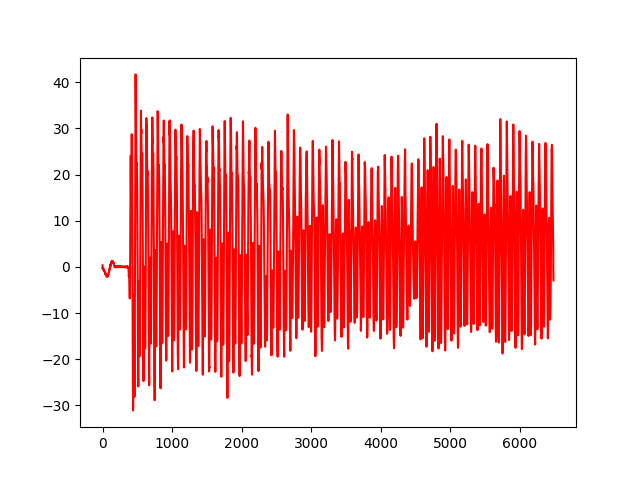

In [389]:
from madgwick import madgwickahrs
import numpy as np
import quaternion as qt

ahrs = madgwickahrs.MadgwickAHRS(0.01)

acc_arr = np.array(imu_acc)
ahrs_acc = np.array(acc_arr)
ahrs_gyr = np.array(imu_gyr)
ahrs_mag = np.array(imu_mag)
quat_list = []

# rescale mag offset

# Initial convergence
# for i in range(2000):
#     ahrs.update_imu([np.mean(ahrs_gyr[:,0]),np.mean(ahrs_gyr[:,1]),np.mean(ahrs_gyr[:,2])],[np.mean(acc_arr[:,0]),np.mean(acc_arr[:,1]),np.mean(acc_arr[:,2])])

# update 
for i,(gy,ac,mg) in enumerate(zip(ahrs_gyr, acc_arr, ahrs_mag)):
    gy_rad = np.deg2rad(gy)
    ahrs.update(gy_rad,ac,mg)
    # print(ahrs.quaternion.q)

    q =  qt.from_float_array(ahrs.quaternion.q)
    quat_list.append(ahrs.quaternion.q)
    ahrs_acc[i] = qt.rotate_vectors(q,acc_arr[i])
    ahrs_acc[i] *= 9.81
    ahrs_acc[i,2] -= 9.81

ahrs_quat = np.array(quat_list)


# data augmentation: mirror x axis
ahrs_acc[0] = -ahrs_acc[0]

print('acc_arr',acc_arr)
print('ahrs_acc',ahrs_acc)    
print('ahrs_quat',ahrs_quat)

print(ahrs_acc.shape)
print(ahrs_quat.shape)

import matplotlib.pyplot as plt
x = range(ahrs_acc.shape[0])
yx = ahrs_acc[:,0]
yy = ahrs_acc[:,1]
yz = ahrs_acc[:,2]




plt.clf()
plt.plot(x, yx, 'r')   # red: ahrs acc x
plt.plot(x, yy, 'g')   # green: ahrs acc y
plt.plot(x, yz, 'b')   # blue: ahrs acc z

plt.show()


# Align imu and vive data

(29364, 3)
(29364, 4)


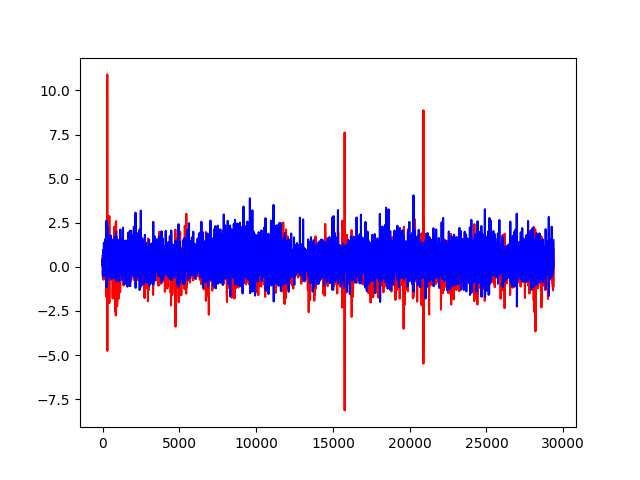

In [365]:
from scipy.signal import resample

# less value: move curve to right
# more value: move curve to left

imu_shift = 400
vive_shift = 425
trim = -100
# mode = 'pad'
mode = 'trim'

a_p = p_c
a_q = vicon_q
a_e = vicon_e
a_cq = vicon_cq

y_p = a_p[imu_shift:trim,:]
y_q = a_q[imu_shift:trim,:]
y_e = a_e[imu_shift:trim,:]
y_cq = a_cq[imu_shift:trim,:]

x_racc = ahrs_acc[vive_shift:trim,:]
x_rgyr = ahrs_gyr[vive_shift:trim,:]
x_mag =  ahrs_mag [vive_shift:trim,:]
x_q = ahrs_quat[vive_shift:trim,:]

if y_p.shape[0] > x_racc.shape[0]:
    if mode == 'pad':
        x_racc = np.pad(x_racc, ((0,y_p.shape[0]-x_racc.shape[0]),(0,0)), 'constant')
        x_rgyr = np.pad(x_rgyr, ((0,y_p.shape[0]-x_racc.shape[0]),(0,0)), 'constant')
        x_mag = np.pad(x_mag, ((0,y_p.shape[0]-x_racc.shape[0]),(0,0)), 'constant')
        x_q = np.pad(x_q, ((0,y_p.shape[0]-x_racc.shape[0]),(0,0)), 'constant')
    else:
         y_p = y_p[:x_racc.shape[0],:]
         y_q = y_q[:x_racc.shape[0],:]
         y_e = a_e[:x_racc.shape[0],:]
         y_cq = a_cq[:x_racc.shape[0],:]
else:
    if mode == 'pad':
        y_p = np.pad(y_p, ((0,x_racc.shape[0]-y_p.shape[0]),(0,0)), 'constant')
        y_q = np.pad(y_q, ((0,x_racc.shape[0]-y_p.shape[0]),(0,0)), 'constant')
        y_e = np.pad(y_e, ((0,x_racc.shape[0]-y_p.shape[0]),(0,0)), 'constant')
        y_cq = np.pad(y_cq, ((0,x_racc.shape[0]-y_p.shape[0]),(0,0)), 'constant')
        
    else:
         x_racc=x_racc[:y_p.shape[0],:]
         x_rgyr=x_rgyr[:y_p.shape[0],:]
         x_mag=x_mag[:y_p.shape[0],:]
         x_q=x_q[:y_p.shape[0],:]


print(y_p.shape)
print(y_q.shape)

x = range(x_racc.shape[0]-1)
yx = np.diff(y_p[:,2]) * 1000
yy = x_racc[:-1,2]


# x = range(x_racc.shape[0]-2)
# yx = np.diff(np.diff(y_p[:,2])) * 1000
# yy = x_racc[:-2,2]  

plt.clf()
plt.plot(x, yx, 'r')   # red vicon pos
plt.plot(x, yy, 'b')   # blue imu acc
plt.show()


In [366]:
# plot center point

import plotly.graph_objs as go

p = y_p[:,:]

trace_1 = go.Scatter3d(x=p[:,0], y=p[:,1], z=p[:,2], mode='lines', name='Ground Truth')

fig = go.Figure([
    trace_1
])


fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.update_scenes(
    aspectmode='data'
)

fig.show()

In [367]:
from Tracking3D_dataset import load_dataset_9d_quat, force_quaternion_uniqueness
from Tracking3D_util import generate_trajectory_6d_quat
import plotly.graph_objs as go


def load_dataset_9d_quat_hsh(gyro_data, acc_data, mag_data, pos_data, ori_data, window_size=200, stride=10):
    init_p = pos_data[window_size//2 - stride//2, :]
    init_q = ori_data[window_size//2 - stride//2, :]

    #x = []
    x_gyro = []
    x_acc = []
    x_mag = []
    y_delta_p = []
    y_delta_q = []
    
    for idx in range(0, gyro_data.shape[0] - window_size - 1, stride):
        #x.append(gyro_acc_data[idx + 1 : idx + 1 + window_size, :])
        x_gyro.append(gyro_data[idx + 1 : idx + 1 + window_size, :])
        x_acc.append(acc_data[idx + 1 : idx + 1 + window_size, :])
        x_mag.append(mag_data[idx + 1 : idx + 1 + window_size, :])

        p_a = pos_data[idx + window_size//2 - stride//2, :]
        p_b = pos_data[idx + window_size//2 + stride//2  + stride%2, :]

        q_a = quaternion.from_float_array(ori_data[idx + window_size//2 - stride//2, :])
        q_b = quaternion.from_float_array(ori_data[idx + window_size//2 + stride//2 + stride%2, :])

        delta_p = np.matmul(quaternion.as_rotation_matrix(q_a).T, (p_b.T - p_a.T)).T
        # delta_p = p_b - p_a

        delta_q = force_quaternion_uniqueness(q_a.conjugate() * q_b)

        y_delta_p.append(delta_p)
        y_delta_q.append(quaternion.as_float_array(delta_q))

    x_gyro = np.reshape(x_gyro, (len(x_gyro), x_gyro[0].shape[0], x_gyro[0].shape[1]))
    x_acc = np.reshape(x_acc, (len(x_acc), x_acc[0].shape[0], x_acc[0].shape[1]))
    x_mag = np.reshape(x_mag, (len(x_mag), x_mag[0].shape[0], x_mag[0].shape[1]))
    y_delta_p = np.reshape(y_delta_p, (len(y_delta_p), y_delta_p[0].shape[0]))
    y_delta_q = np.reshape(y_delta_q, (len(y_delta_q), y_delta_q[0].shape[0]))

    return [x_gyro, x_acc, x_mag], [y_delta_p, y_delta_q], init_p, init_q

def generate_trajectory_6d_hsh(init_p, init_q, y_delta_p, y_delta_q):
    cur_p = np.array(init_p)
    cur_q = quaternion.from_float_array(init_q)
    pred_p = []
    pred_p.append(np.array(cur_p))

    for [delta_p, delta_q] in zip(y_delta_p, y_delta_q):
        cur_p = cur_p + np.matmul(quaternion.as_rotation_matrix(cur_q), delta_p.T).T
        # cur_p = cur_p + delta_p
        cur_q = cur_q * quaternion.from_float_array(delta_q).normalized()
        pred_p.append(np.array(cur_p))
    # print(delta_q)
    # print(type(delta_q))
    return np.reshape(pred_p, (len(pred_p), 3))

print(y_q.shape)

[cur_x_gyro, cur_x_acc, cur_x_mag], [cur_y_delta_p, cur_y_delta_q], init_p, init_q = load_dataset_9d_quat_hsh(x_rgyr,x_racc,x_mag,y_p,y_cq,100,5)

print(cur_y_delta_q.shape)

gt_trajectory = generate_trajectory_6d_hsh(init_p, init_q, cur_y_delta_p, cur_y_delta_q)


yx = gt_trajectory[:,0]
yy = gt_trajectory[:,1]
yz = gt_trajectory[:,2]


trace_1 = go.Scatter3d(x=yx, y=yy, z=yz, mode='lines', name='Ground Truth')

fig = go.Figure([
    trace_1
])


fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.update_scenes(
    aspectmode='data'
)

fig.show()

(29364, 4)
(5853, 4)


# save preprocessed data

In [368]:
print(x_racc.shape)
print(x_rgyr.shape)
print(x_mag.shape)

print(y_p.shape)
print(y_q.shape)
print(y_e.shape)
print(y_cq.shape)

# time_array =  np.array(range(0,x_racc.shape[0]))*10
x_data = np.concatenate([x_racc,x_rgyr,x_mag],axis=1)
y_data = np.concatenate([y_p,y_q,y_e,y_cq],axis=1)

np.savetxt(syn_path+"syn_imu.csv",   x_data,   delimiter=",", header="ax,ay,az,gx,gy,gz,mx,my,mz")
np.savetxt(syn_path+"syn_gt.csv",   y_data,   delimiter=",", header="px,py,pz,qx,qy,qz,qw,ex,ey,ez,cqx,cqy,cqz,cqw")

print(f"saved imu file in {syn_path}syn_imu.csv")
print(f"saved gt file in {syn_path}syn_gt.csv")

(29364, 3)
(29364, 3)
(29364, 3)
(29364, 3)
(29364, 4)
(29364, 3)
(29364, 4)
saved imu file in D:/onedrive_ntpu/OneDrive - 國立臺北大學/vicon dataset 2/syn3/walk_8/slow_noswing_sh_12_arm/syn_imu.csv
saved gt file in D:/onedrive_ntpu/OneDrive - 國立臺北大學/vicon dataset 2/syn3/walk_8/slow_noswing_sh_12_arm/syn_gt.csv
